In [1]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage import exposure
import random
import sys

In [2]:
im1 = np.array(Image.open('band1.gif', 'r'))
im2 = np.array(Image.open('band2.gif', 'r'))
im3 = np.array(Image.open('band3.gif', 'r'))
im4 = np.array(Image.open('band4.gif', 'r'))

In [3]:
k=3

In [4]:
# 2. Input satellite images, imageInput (512, 512,4)

imageinput=np.array([im1,im2,im3,im4])
print(imageinput.reshape(512,512,4).shape)
print(imageinput[0][0].shape)


(512, 512, 4)
(512,)


In [5]:
# 3. Initialize clusteredImage as the output image

#clusteredImage 

In [6]:
# 4. Select k random x,y co-ordinates and extract pixel values from imageInput 

coord = np.array(([265,190],[32,436],[30,124]))

c1=[]
c2=[]
c3=[]
c4=[]
for i in range(3):
    c1.append(im1[coord[i][0],coord[i][1]])
    c2.append(im2[coord[i][0],coord[i][1]])
    c3.append(im3[coord[i][0],coord[i][1]])
    c4.append(im4[coord[i][0],coord[i][1]])

    
initCentroids=np.array([c1,c2,c3,c4]).T
print(initCentroids.shape)

# we will be updating centroids later
centroids = initCentroids


(3, 4)


In [7]:
#initCentroids (3, 4)
#(512, 512, 4)

def euclidean_dist(x1,x2):
    dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5
    return dist


def clustering(k,imageinput,centroids):
    min_dist = sys.maxsize

    classData = np.zeros((512*512,1))

    for i in range(512):
        for j in range(512):
            for x in range(k):
                distance = euclidean_dist(imageinput[:,i,j],centroids[x])


                if(min_dist > distance):
                    min_dist = distance
                    label = x


            classData[i] = label
            min_dist = sys.maxsize
    return classData

def updateCentroids(imageinput,centroids,classData):
    sum=[0,0,0,0]
    total = 0
    updatedCentroids = np.zeros((k,4))

    for x in range (k):
        for i in range(512):
            for j in range(512):
                if classData[i*j]==x:
                    sum = np.array(sum) + imageinput[:,i,j]
                    total+=1
        sum = sum/total
        updatedCentroids[x] = sum
        sum = [0,0,0,0]
        total = 0
    return updatedCentroids
        


### Step 5

In [8]:
classData = clustering(k,imageinput,centroids)

<ipython-input-7-73763fe8f4c0>:5: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


In [9]:
updatedCentroids = np.round(updateCentroids(imageinput,centroids,classData))


In [10]:
print(centroids)
print()
print(updatedCentroids)

[[13 15 20 11]
 [ 6  6  9 17]
 [ 6  7  9 21]]

[[ 9. 10. 13. 20.]
 [ 8.  9. 11. 22.]
 [ 7.  9. 11. 22.]]


In [ ]:
### loop until stopping criteria is met

count = 0
while(count < 10):
    classData = clustering(k,imageinput,centroids)
    updatedCentroids = np.round(updateCentroids(imageinput,centroids,classData))
    if (centroids==updatedCentroids).all():
        print("matched")
        break
    else:
        centroids = updatedCentroids
    count+=1
    

### step 6

(262144, 1)
(512, 512)


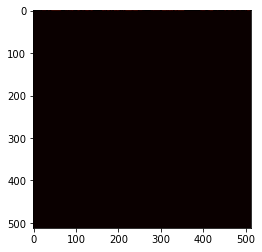

In [17]:
print(classData.shape)
cl=classData.reshape(512,512)

#cl = np.reshape(cl,(1, cl.size))
print(cl.shape)
plt.imshow(cl, cmap='hot')
plt.show()

                    